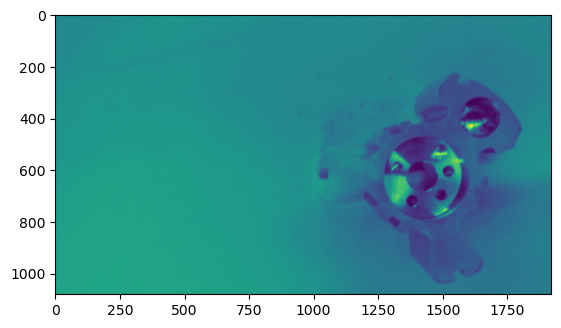

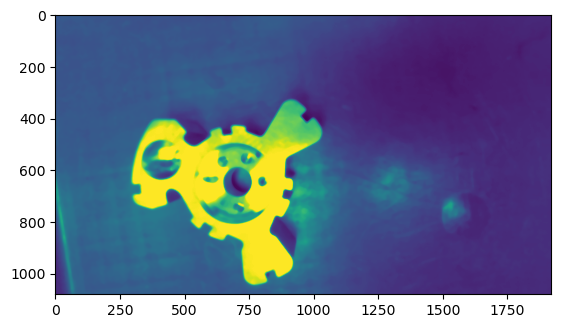

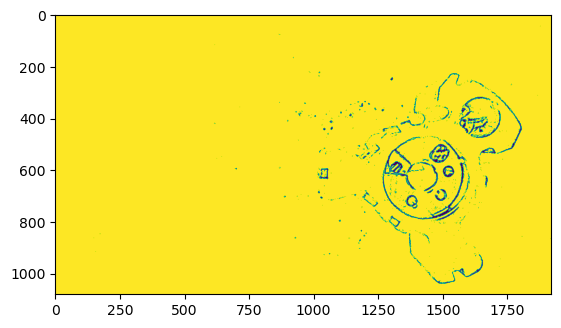

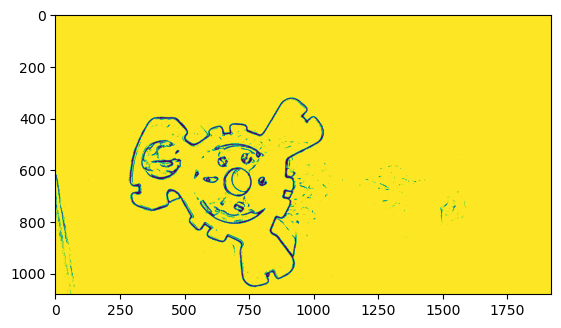

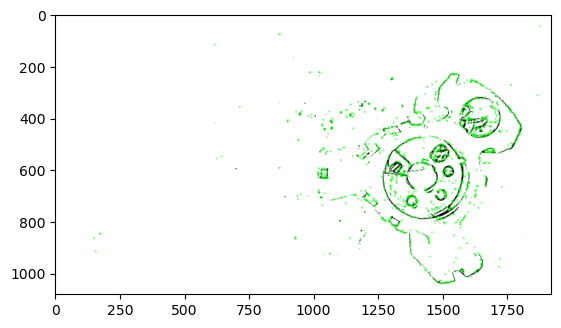

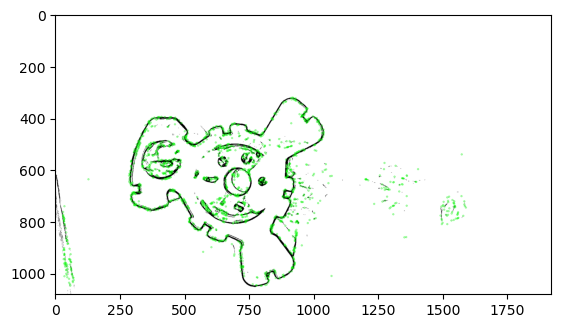

1435 571


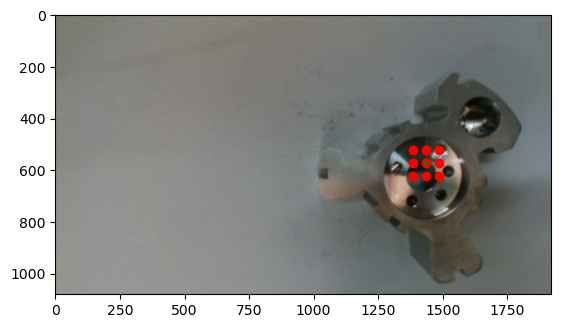

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from segment_anything import build_sam, SamPredictor, build_sam_vit_b
from huggingface_hub import hf_hub_download
from segment_anything import sam_model_registry

MODEL_INSTALLED = False

def find_rotation_angle(image1, image2) -> tuple[list, list]:
    # Convert images to grayscale
    gray1 = cv.imread(image1, cv.IMREAD_GRAYSCALE)
    gray1 = cv.medianBlur(gray1, 7)
    
    gray2 = cv.imread(image2, cv.IMREAD_GRAYSCALE)
    gray2 = cv.medianBlur(gray2, 13)
    
    plt.imshow(gray1)
    plt.show()
    
    plt.imshow(gray2)
    plt.show()
    
    gray1 = cv.adaptiveThreshold(gray1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    gray2 = cv.adaptiveThreshold(gray2, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    
    plt.imshow(gray1)
    plt.show()
    
    plt.imshow(gray2)
    plt.show()


    # Initialize ORB detector
    orb = cv.ORB_create(nfeatures=100, scoreType=cv.ORB_FAST_SCORE)
    keypoints1 = orb.detect(gray1, None)
    keypoints2 = orb.detect(gray2, None)
    
    image1_kp = cv.drawKeypoints(gray1, keypoints1, None, color=(0,255,0), flags=0)
    plt.imshow(image1_kp), plt.show()
    
    image2_kp = cv.drawKeypoints(gray2, keypoints2, None, color=(0,255,0), flags=0)
    plt.imshow(image2_kp), plt.show()
    
    keypoints1 = cv.KeyPoint_convert(keypoints1)
    keypoints2 = cv.KeyPoint_convert(keypoints2)

    
    return keypoints1, keypoints2


def find_keypoint_average(keypoints):
    x_avg = 0
    y_avg = 0
    
    x_sum = 0
    y_sum = 0
    
    keypoints_len = len(keypoints)
    
    for keypoint in keypoints:
        x_sum += keypoint[0]
        y_sum += keypoint[1]
        
    x_avg = int(x_sum / keypoints_len)
    y_avg = int(y_sum / keypoints_len)
    
    return x_avg, y_avg

# Load images

# Find rotation angle
keypoints1, keypoints2 = find_rotation_angle("image1.jpg", "image2.jpg")
# print("Rotation Angle:", rotation_angle)

x1, y1 = find_keypoint_average(keypoints1)
print(x1, y1)

pts = np.array([[x1, y1], [x1+50, y1], [x1, y1+50], [x1+50, y1+50],
                          [x1-50, y1], [x1, y1-50], [x1-50, y1-50],
                          [x1+50, y1-50], [x1-50, y1+50]])

image = plt.imread("image1.jpg")
plt.plot(x1, y1, "og", markersize=2)
plt.scatter(pts[:, 0], pts[:, 1], marker="o", color="red")
plt.imshow(image)

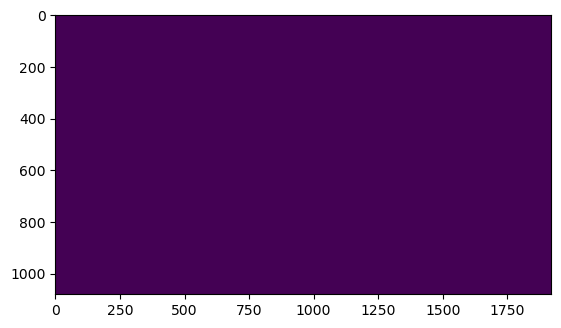

In [3]:
from segment_anything import build_sam, SamPredictor, build_sam_vit_b
from huggingface_hub import hf_hub_download
from segment_anything import sam_model_registry


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

input_point = pts
input_label = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

img1 = cv.imread("image1.jpg")

model_type = "vit_b"

chkpt_path = hf_hub_download("ybelkada/segment-anything", "checkpoints/sam_vit_b_01ec64.pth")
sam = sam_model_registry[model_type](checkpoint=chkpt_path)

predictor = SamPredictor(build_sam_vit_b(checkpoint=chkpt_path))
predictor.set_image(img1)


masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

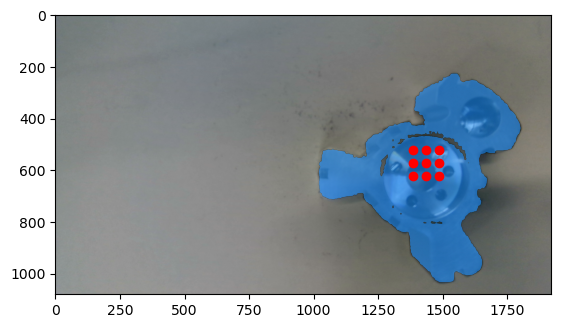

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [4]:
plt.imshow(img1)
show_mask(masks[0], plt.gca())
plt.scatter(pts[:, 0], pts[:, 1], marker="o", color="red")
plt.show() 

print(masks[0])

In [5]:
masks.shape

(3, 1080, 1920)

[[1021.  229. 1802. 1034.]
 [1272.  471. 1603.  994.]
 [1317.  473. 1543.  683.]]


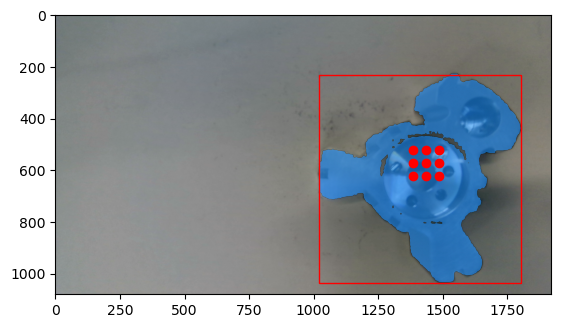

781.0 805.0


In [14]:
import torch
from torchvision.ops import masks_to_boxes
import matplotlib.patches as patches 

masks_tensor = torch.from_numpy(masks)

boxes = np.array(masks_to_boxes(masks_tensor))
print(boxes)

# [[xm, ym], [xM, yM]]
bbox_points = [[boxes[0][0], boxes[0][1]], [boxes[0][2], boxes[0][3]]]

# [xm, yM] bottom left point
lower_left = (bbox_points[0][0], bbox_points[0][1])

# Calculating width and height
rect_width = bbox_points[1][0] - bbox_points[0][0]
rect_height = bbox_points[1][1] - bbox_points[0][1]


fig, ax = plt.subplots()
plt.imshow(img1)
show_mask(masks_tensor[0], plt.gca())
plt.scatter(pts[:, 0], pts[:, 1], marker="o", color="red")

rect = patches.Rectangle(lower_left, rect_width, rect_height, linewidth=1, 
                         edgecolor='r', facecolor="none") 

# Add the patch to the Axes 
ax.add_patch(rect) 
plt.show() 

print(rect_width, rect_height)

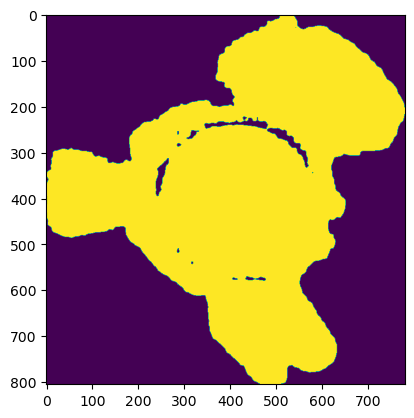

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [15]:
best_mask = masks[0]

# Cropping the mask:
cropped_img = best_mask[int(lower_left[1]):int(lower_left[1]+rect_height), 
                        int(lower_left[0]):int(lower_left[0]+rect_width)]

plt.imshow(cropped_img)
plt.show()

print(cropped_img)

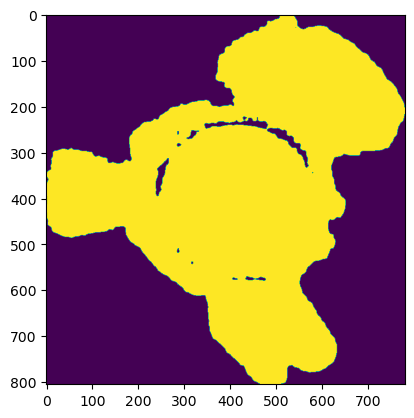

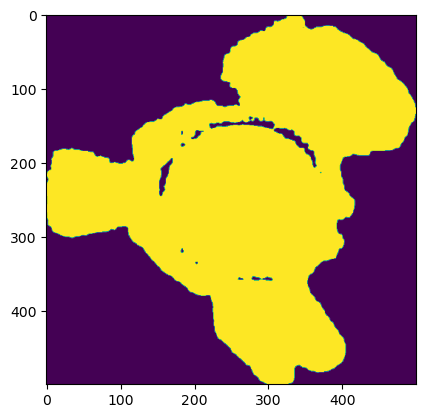

In [16]:
# Reshape as float32 to allow cv.resize to work:
cropped_img = cropped_img.reshape((int(rect_height), int(rect_width))).astype('float32')

plt.imshow(cropped_img)
plt.show()

resized_img = cv.resize(cropped_img, (500, 500), interpolation=cv.INTER_LINEAR)
plt.imshow(resized_img)
plt.show()

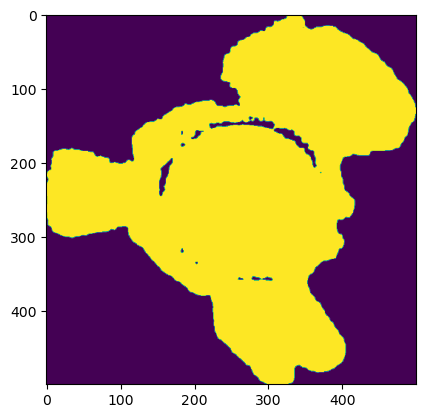

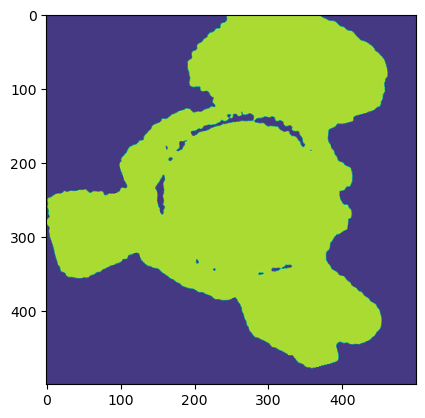

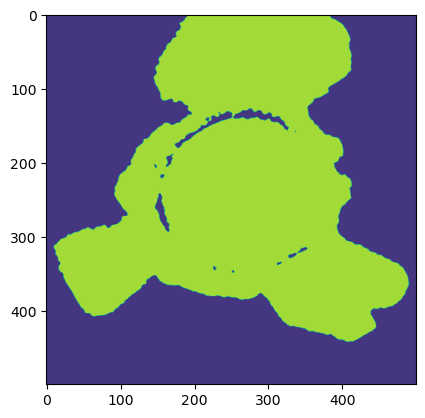

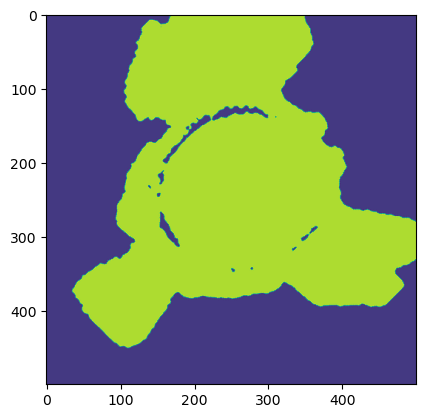

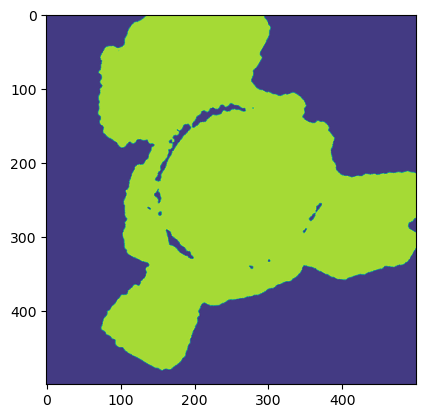

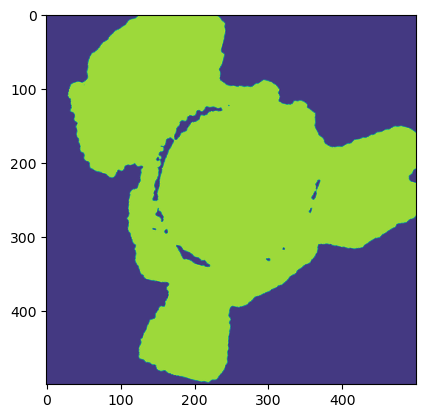

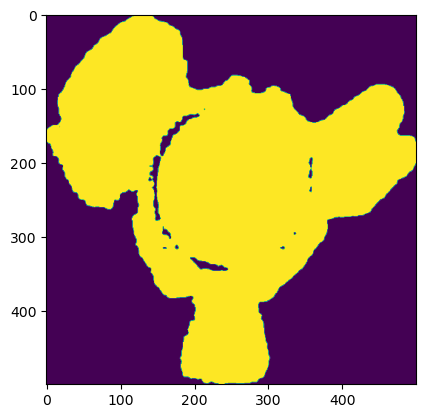

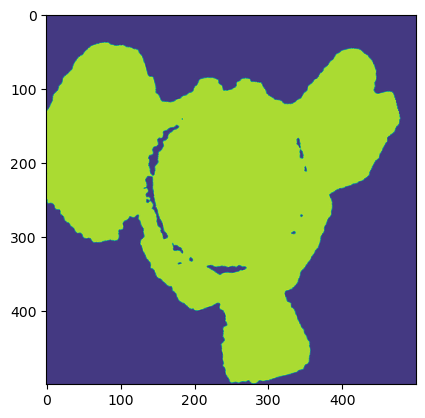

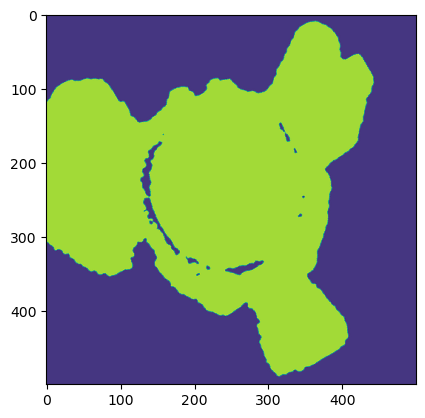

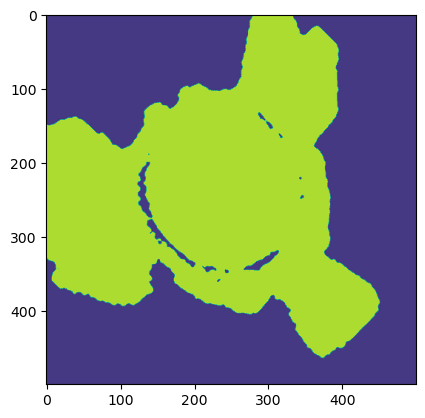

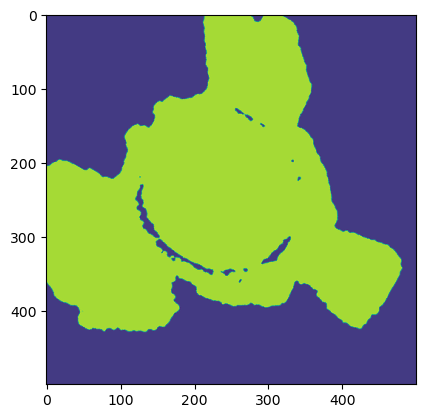

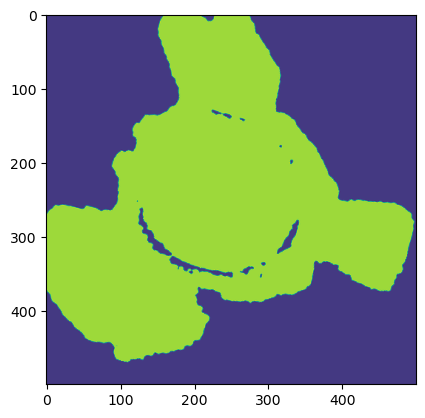

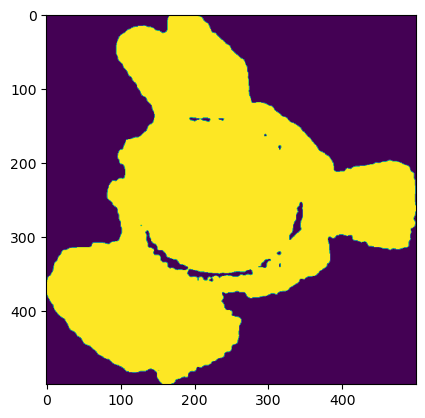

In [39]:
# Now we compare image overlaps. 
from scipy import ndimage

i = 0
while i <= 180:
    rotated_img = ndimage.rotate(resized_img, i, reshape=False)
    plt.imshow(rotated_img)
    plt.show()
    
    i += 15

# rotated_img = ndimage.rotate(resized_img, 20, reshape=False)

# plt.imshow(rotated_img)

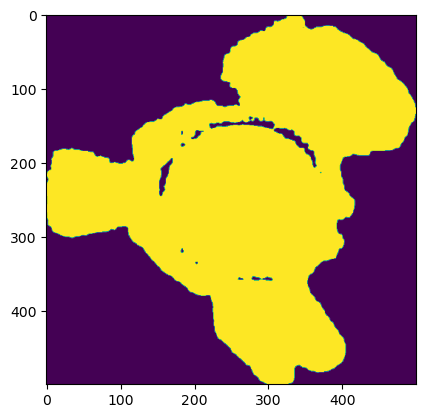

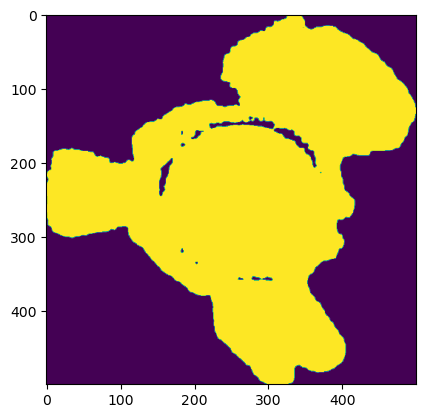

In [37]:
plt.imshow(resized_img)
plt.show()

plt.imshow(rotated_img)
plt.show()

2.5469972e-13


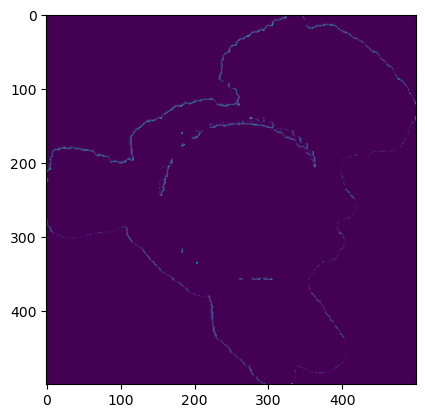

In [38]:
absdiff = abs(resized_img - rotated_img)

plt.imshow(absdiff)

diff_measure = np.sum(absdiff)
print(diff_measure)

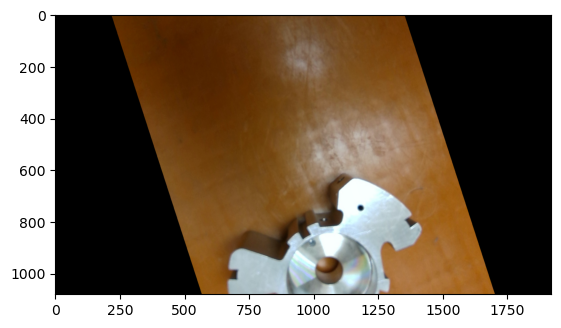

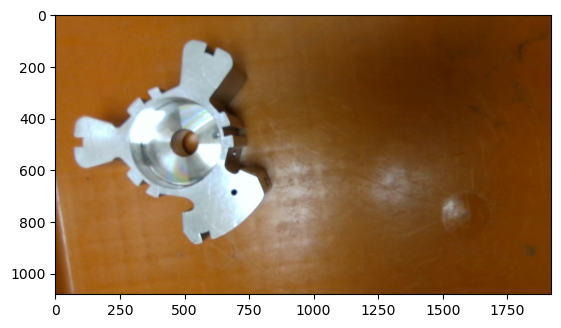

In [41]:
img1 = cv.imread("screenshot_2024-05-02_17-22-50.jpg")
img2 = cv.imread("screenshot_2024-05-02_17-23-01.jpg")

rotated_img = ndimage.rotate(img1, 108, reshape=False)
plt.imshow(rotated_img)
plt.show()

plt.imshow(img1)
plt.show()


[[[1426.5  627.5  155.4]]]
[1426.5  627.5  155.4]


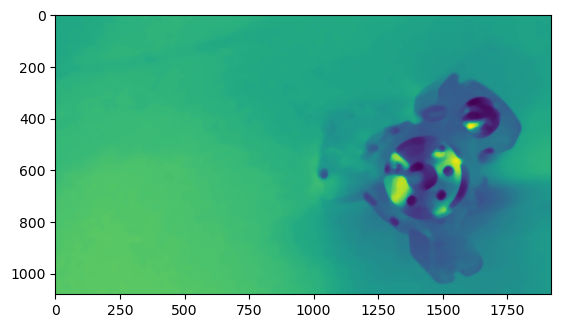

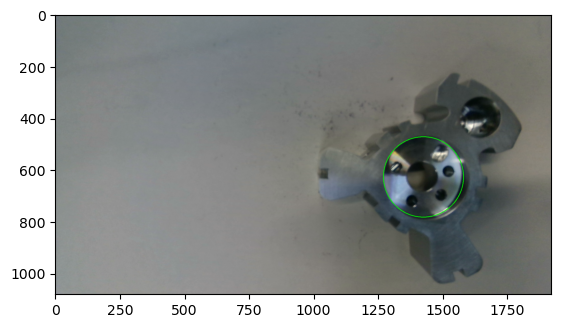

In [55]:
import numpy as np
import cv2

img = cv2.imread('image1.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.medianBlur(gray, 25) #cv2.bilateralFilter(gray,10,50,50)

minDist = 400
param1 = 30 #500
param2 = 50 #200 #smaller value-> more false circles
minRadius = 100
maxRadius = 400 #10

# docstring of HoughCircles: HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
print(circles)
print(circles[0][0])

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        
plt.imshow(blurred)
plt.show()
plt.imshow(img)

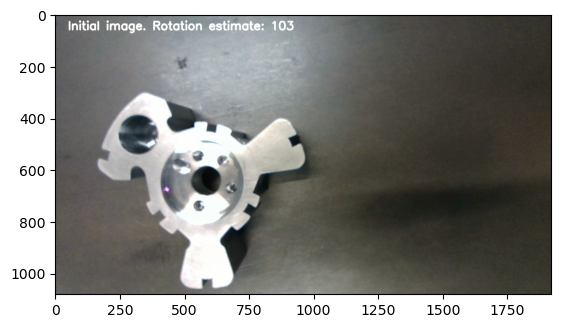

In [71]:
best_angle = 103

image1 = cv.imread("image1.jpg")

cv.putText(image1,
               f"Initial image. Rotation estimate: {best_angle}",
               (50, 60), cv.FONT_HERSHEY_SIMPLEX,
               1.5, (255, 255, 255), 5)

plt.imshow(image1)
plt.show()